In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import matplotlib.pyplot as plt 
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, roc_auc_score,
                            PrecisionRecallDisplay)

# 1. EDA & Preprocessing

In [2]:
colnames = ['Age', 'Employment type', 'Weighting factor', 'Level of education', 'Schooling/training period', 
               'Martial status', 'Employment area', 'Partnership', 'Ethnicity', 'Gender', 'Gains on financial assets',
              'Losses on financial assets', 'Weekly working time', 'Country of birth', 'Income']

# read the data file, set colnames and replace '?' by NaN
data = pd.read_csv('einkommen.train.csv', header=None, names=colnames, sep=',\s', na_values=["?"], engine = 'python')
# replace the 'income' col with 0 (<=50k) and 1 (>50k)
data.loc[data['Income'] == '>50K', 'Income'] = 1
data.loc[data['Income'] == '<=50K', 'Income'] = 0

In [3]:
data.shape

(30000, 15)

In [4]:
data.sample(15, random_state = 14)

,Age,Employment type,Weighting factor,Level of education,Schooling/training period,Martial status,Employment area,Partnership,Ethnicity,Gender,Gains on financial assets,Losses on financial assets,Weekly working time,Country of birth,Income
6947,37,Self-emp-inc,27997,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,50,United-States,NaN
24408,39,Private,121468,Bachelors,13,Never-married,Exec-managerial,Own-child,Asian-Pac-Islander,Female,0,0,35,United-States,NaN
11085,28,NaN,80165,Some-college,10,Divorced,NaN,Not-in-family,White,Female,0,0,30,United-States,NaN
21625,23,Private,183358,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Puerto-Rico,NaN
3207,23,NaN,123983,Bachelors,13,Never-married,NaN,Own-child,Other,Male,0,0,40,United-States,0
26650,34,Private,287737,Some-college,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,1485,40,United-States,NaN
16382,17,NaN,148769,HS-grad,9,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,NaN
4248,51,Private,302146,11th,7,Never-married,Other-service,Not-in-family,Black,Female,0,0,40,United-States,0
28258,28,Private,336951,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,NaN
21639,33,Private,185336,Assoc-voc,11,Married-civ-spouse,Adm-clerical,Wife,Black,Female,0,0,40,United-States,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         30000 non-null  int64 
 1   Employment type             28323 non-null  object
 2   Weighting factor            30000 non-null  int64 
 3   Level of education          30000 non-null  object
 4   Schooling/training period   30000 non-null  int64 
 5   Martial status              30000 non-null  object
 6   Employment area             28318 non-null  object
 7   Partnership                 30000 non-null  object
 8   Ethnicity                   30000 non-null  object
 9   Gender                      30000 non-null  object
 10  Gains on financial assets   30000 non-null  int64 
 11  Losses on financial assets  30000 non-null  int64 
 12  Weekly working time         30000 non-null  int64 
 13  Country of birth            29461 non-null  ob

In [6]:
data.describe(include='object')

,Employment type,Level of education,Martial status,Employment area,Partnership,Ethnicity,Gender,Country of birth,Income
count,28323,30000,30000,28318,30000,30000,30000,29461,5000
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,0
freq,20901,9692,13768,3802,12138,25636,20070,26871,3779


In [8]:
data_full = copy.deepcopy(data)
# remove the last 25000 rows (not the data we want to train the model with)
data = data.iloc[:5000, :]

In [9]:
data.shape

(5000, 15)

## 2.1 Missing data

In [72]:
data.isna().sum() 

Age                             0
Employment type               331
Weighting factor                0
Level of education              0
Schooling/training period       0
Martial status                  0
Employment area               331
Partnership                     0
Ethnicity                       0
Gender                          0
Gains on financial assets       0
Losses on financial assets      0
Weekly working time             0
Country of birth               97
Income                          0
dtype: int64

-> Only 3 columns contain missing data: Employment type, Employment area and Country of birth
Let's look at country of birth first.

In [75]:
# I want to look at percentages here so I use /len(data)*100
data['Country of birth'].value_counts()/len(data)*100

Country of birth
United-States                 89.30
Mexico                         2.08
Canada                         0.56
Philippines                    0.44
Germany                        0.44
El-Salvador                    0.32
Puerto-Rico                    0.32
England                        0.32
Jamaica                        0.30
China                          0.30
Cuba                           0.28
Dominican-Republic             0.26
Italy                          0.24
India                          0.24
Iran                           0.22
Vietnam                        0.20
Taiwan                         0.20
Guatemala                      0.20
Poland                         0.18
South                          0.18
Japan                          0.18
Portugal                       0.14
Greece                         0.12
Haiti                          0.12
Columbia                       0.10
Nicaragua                      0.10
Trinadad&Tobago                0.08
Ireland    

<Axes: xlabel='Country of birth'>

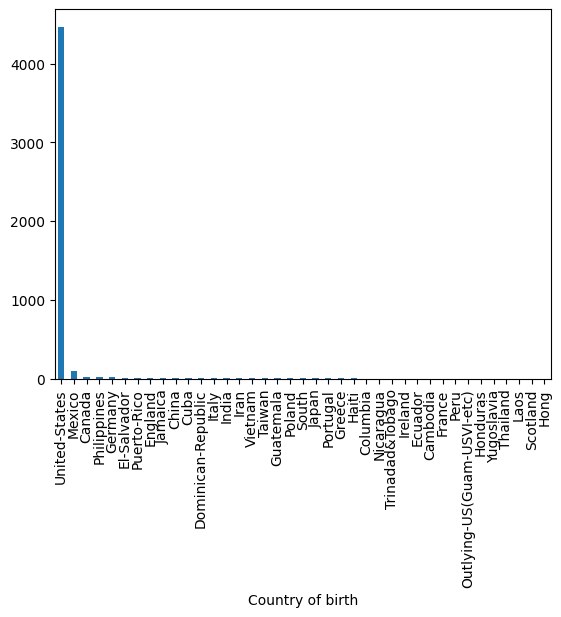

In [73]:
# use rot = 90 to rotate the x-axis labels by 90 degrees for readability
data['Country of birth'].value_counts().plot.bar(rot=90)

-> most frequent imputation makes sense

In [11]:
# since employment type 6 area have the same number of missing values, it could be that the same rows are affected
sum(data['Employment type'].isna() == data['Employment area'].isna())
# -> the two columns should be imputed the same way
employment_rows = data[data['Employment type'].isna()]
employment_rows.sample(20)

,Age,Employment type,Weighting factor,Level of education,Schooling/training period,Martial status,Employment area,Partnership,Ethnicity,Gender,Gains on financial assets,Losses on financial assets,Weekly working time,Country of birth,Income
4080,19,NaN,208874,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,0
149,43,NaN,174662,Some-college,10,Divorced,NaN,Not-in-family,White,Female,0,0,40,United-States,0
2105,17,NaN,103810,12th,8,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,0
2327,25,NaN,41107,Bachelors,13,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,Canada,0
221,64,NaN,187656,1st-4th,2,Divorced,NaN,Not-in-family,White,Male,0,0,40,United-States,0
3119,35,NaN,169809,Bachelors,13,Married-civ-spouse,NaN,Husband,White,Male,0,0,20,United-States,0
2427,20,NaN,287681,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,36,United-States,0
3096,22,NaN,175586,HS-grad,9,Never-married,NaN,Unmarried,Black,Female,0,0,35,United-States,0
1312,20,NaN,244689,Some-college,10,Never-married,NaN,Not-in-family,White,Female,0,0,25,United-States,0
4212,54,NaN,187221,7th-8th,4,Never-married,NaN,Not-in-family,White,Female,0,0,25,United-States,0


In [13]:
for column in data:
    print(column, ':', data[column].unique())
# columns with '?' in them: 
# Employment type, Employment area, Country of Birth, Income (last 25k)

# sort the columns into categorical, numerical and binary:
categorical_features = ['Employment type', 'Level of education', 'Martial status', 'Employment area', 
                        'Partnership', 'Ethnicity', 'Country of birth']
numerical_features = ['Age', 'Weighting factor', 'Schooling/training period', 'Gains on financial assets',
              'Losses on financial assets', 'Weekly working time']
binary_features = ['Gender']

Age : [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83]
Employment type : ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay']
Weighting factor : [ 77516  83311 215646 ... 212120 245880  54947]
Level of education : ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
Schooling/training period : [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Martial status : ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
Employment area : ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tec

(array([845., 934., 884., 969., 633., 379., 246.,  74.,  27.,   9.]),
 array([17. , 24.3, 31.6, 38.9, 46.2, 53.5, 60.8, 68.1, 75.4, 82.7, 90. ]),
 <BarContainer object of 10 artists>)

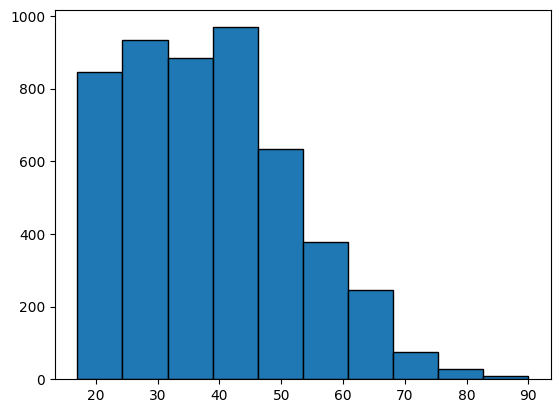

In [14]:
plt.hist(x=data['Age'].values, edgecolor='black')

In [17]:
# how are the class labels distributed?
data['Income'].value_counts(normalize=True)

Income
0    0.7558
1    0.2442
Name: proportion, dtype: float64

<Axes: >

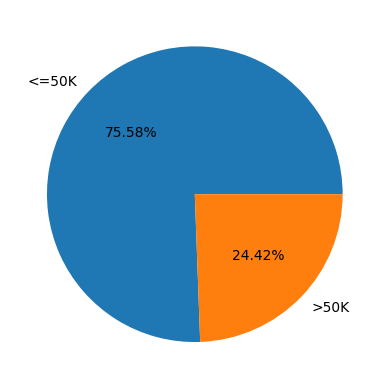

In [18]:
pd.value_counts(data['Income']).plot(kind='pie',autopct='%1.2f%%', ylabel = '', labels = ['<=50K', '>50K',])

# 2. Train/Test split

In [19]:
# seperate the data
X = data.iloc[:, :14]
y = data.iloc[:, 14]
y = y.astype('int')

In [20]:
# use stratify = y in order to make sure the target label distribution is the same for train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99, stratify=y)

Look at the target variable distribution of training & test data.

<Axes: >

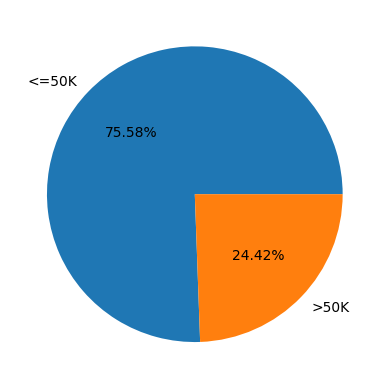

In [21]:
pd.value_counts(y_train).plot(kind='pie',autopct='%1.2f%%', ylabel = '', labels = ['<=50K', '>50K',])

The distribution closely matches that of the whole dataset, as seen below.

<Axes: >

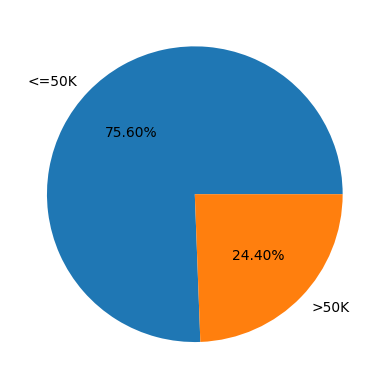

In [22]:
pd.value_counts(y_test).plot(kind='pie',autopct='%1.2f%%', ylabel = '', labels = ['<=50K', '>50K',])

# Test section

 TREE CANT DEAL WITH CATEGORICAL DATA

In [76]:
from sklearn.tree import DecisionTreeClassifier

pipe_cat_tree = Pipeline([
    # impute missing data by most frequent
    ('imp', SimpleImputer(strategy = 'most_frequent', missing_values = np.nan))
])
# only categorical columns have missing values -> no imputation needed for numerical & binary columns
pipe_num_tree = Pipeline([
    ('minmax', MinMaxScaler())
])
column_trans_tree = ColumnTransformer(transformers = 
    [('cat', pipe_cat_tree, categorical_features),                # categorical
    ('num', pipe_num_tree, numerical_features)])                     # binary/ordinal     
column_trans_tree

pipe_tree = Pipeline([
    ('preprocessor', column_trans_tree),
    ('classifier', DecisionTreeClassifier(random_state=99)) 
])

In [80]:
params_tree = {}

# max_depth = maximum depth of each tree, 
# None = nodes are expanded until all number of samples in each leaf < min_samples_split
# previously tested: [None, 10, 20]-> best = None (all data), best = 10 (20% test split)
params_tree['classifier__max_depth'] = [None, 10, 20]

# min_samples_split = minimum number of samples required to split an internal node
# previously tested: [2, 5, 10] -> best = 10 -> AGAIN (bc at boundary) (all data), best = 5 (20% test split)
params_tree['classifier__min_samples_split'] = [2, 5, 10]

# min_samples_leaf = minimum number of samples required to be at a leaf node
# previously tested: [1, 2, 4] -> best = 2 (all data), best = 1 (20% test split)
params_tree['classifier__min_samples_leaf'] = [1, 2, 4]

# first iteration best score: 0.9083165385335306 (all data), score = 0.9135427084197859 (20% test split)

In [81]:
grid_tree = GridSearchCV(pipe_tree, params_tree, cv=5, scoring = 'roc_auc')
grid_tree.fit(X_train, y_train)

ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 186, in fit
    X, y = self._validate_data(
  File "C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 579, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'Private'


# 3. Model Selection

## 3.1 Pipeline

In [27]:
# proprocessing based on column types
pipe_cat = Pipeline([
    # impute missing data by most frequent
    ('imp', SimpleImputer(strategy = 'most_frequent', missing_values = np.nan)),  
    ('encode', OneHotEncoder(handle_unknown='ignore')),  
])
# only categorical columns have missing values -> no imputation needed for numerical & binary columns
pipe_num = Pipeline([
    ('minmax', MinMaxScaler()),  
    ('stdscale', StandardScaler()),
])
pipe_bin = Pipeline([
    ('encode', OrdinalEncoder()),  
])
column_trans = ColumnTransformer(transformers = 
    [('cat', pipe_cat, categorical_features),                # categorical
    ('num', pipe_num, numerical_features),                   # numerical
    ('bin', pipe_bin, binary_features)])                     # binary/ordinal     
column_trans

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Employment type', 'Level of education',
                                  'Martial status', 'Employment area',
                                  'Partnership', 'Ethnicity',
                                  'Country of birth']),
                                ('num',
                                 Pipeline(steps=[('minmax', MinMaxScaler()),
                                                 ('stdscale',
                                                  StandardScaler())]),
                                 ['Age', 'Weighting factor',
                                  'Schooling/training period',
                                  'Gains on financial assets',
                                  'Losses on financial assets',
                                  'Weekly working time']),
                                ('bin',
                                 Pipeline(steps=[('encode', OrdinalEncoder())]),
                                 ['Gender'])])

As seen in the illustration above, the pipeline does different operations based on the column type. 
Categorical column (3+ categories):
- Impute missing data by most frequent
- One hot encode the column
Numerical column: 
- 

## 3.2 Random Forests

In [28]:
pipe_rf = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', RandomForestClassifier(random_state=99)) 
])
pipe_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier', RandomForestClassifier(random_state=99))])

### 3.2.1 Hyperparameter tuning

In [29]:
params_rf = {}
# n_estimators = number of trees used
# previously tested: [50, 100, 200] -> best = 200 -> AGAIN (bc at boundary) (all data), best = 100 (20% test split)
params_rf['classifier__n_estimators'] = [50, 100, 200]

# max_depth = maximum depth of each tree, 
# None = nodes are expanded until all number of samples in each leaf < min_samples_split
# previously tested: [None, 10, 20]-> best = None (all data), best = 10 (20% test split)
params_rf['classifier__max_depth'] = [None, 10, 20]

# min_samples_split = minimum number of samples required to split an internal node
# previously tested: [2, 5, 10] -> best = 10 -> AGAIN (bc at boundary) (all data), best = 5 (20% test split)
params_rf['classifier__min_samples_split'] = [2, 5, 10]

# min_samples_leaf = minimum number of samples required to be at a leaf node
# previously tested: [1, 2, 4] -> best = 2 (all data), best = 1 (20% test split)
params_rf['classifier__min_samples_leaf'] = [1, 2, 4]

# first iteration best score: 0.9083165385335306 (all data), score = 0.9135427084197859 (20% test split)

In [30]:
# -> use the best params and try again on the others (max_depth = None not needed since its the default)
pipe_rf = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', RandomForestClassifier(random_state=99, min_samples_leaf = 2)) 
])
pipe_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=2, random_state=99))])

In [31]:
params_rf2 = {}
# previously tested: [200, 350, 500] -> best = 500 -> AGAIN (bc at boundary)
params_rf2['classifier__n_estimators'] = [200, 350, 500]
# previously tested: [10, 15, 20] -> best = 20 -> AGAIN (bc at boundary)
params_rf2['classifier__min_samples_split'] = [10, 15, 20]
# previously tested: [None, 'balanced', {1: 76, 0: 24}] -> best = None
params_rf2['classifier__class_weight'] = [None, 'balanced', {1: 76, 0: 24}]

In [32]:
params_rf3 = {}
# previously tested: [500, 750, 1000] -> best = 500 -> AGAIN (to find exact number)
params_rf3['classifier__n_estimators'] = [500, 750, 1000]
# previously tested: [20, 30, 40] -> best = 40 -> AGAIN (bc at boundary)
params_rf3['classifier__min_samples_split'] = [20, 30, 40]

In [33]:
params_rf4 = {}
# previously tested: [500, 750, 1000] -> best = 400 -> AGAIN (to find exact number)
params_rf4['classifier__n_estimators'] = [400, 450, 500]
# previously tested: [40, 60, 80] -> best = 40 -> AGAIN (to find exact number)
params_rf4['classifier__min_samples_split'] = [40, 60, 80]

In [34]:
grid_rf = GridSearchCV(pipe_rf, params_rf, cv=5, scoring = 'roc_auc')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Employment '
                                                                          'type',
                                                                          'Level '
                                                                          'of '
                                                                          'education',
                                                                          'Martial '
                                                                          'status',
                                                                          'Employment '
                                                                          'area',
                                                                          'Partnership',
                                                                          'Ethnicity',
                                                                          'Country '
                                                                          'of '
                                                                          'birth']),
                                                                        ('num'...
                                                                          'working '
                                                                          'time']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encode',
                                                                                          OrdinalEncoder())]),
                                                                         ['Gender'])])),
                                       ('classifier',
                                        RandomForestClassifier(min_samples_leaf=2,
                                                               random_state=99))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [35]:
grid_rf.best_score_

0.9098400825687314

In [36]:
grid_rf.best_params_

{'classifier__max_depth': 20,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 200}

### 3.2.2 Final Random Forest

In [37]:
pipe_rf_final = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', RandomForestClassifier(random_state=99, min_samples_leaf = 1, n_estimators = 100,
                                         min_samples_split = 5)) 
])

FEATURE IMPORTANCES:

In [84]:
# Extract the trained random forest model from the pipeline
rf_model = pipe_rf_final.named_steps['classifier']

# Extract feature importances
importances = rf_model.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Extract feature names from each transformer
cat_feature_names = pipe_rf_final.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encode'].get_feature_names_out(categorical_features)
num_feature_names = pipe_rf_final.named_steps['preprocessor'].named_transformers_['num'].named_steps['minmax'].get_feature_names_out(numerical_features)
bin_feature_names = pipe_rf_final.named_steps['preprocessor'].named_transformers_['bin'].named_steps['encode'].categories_[0]  # Assuming there's only one binary feature

# Combine feature names from all transformers
feature_names = np.concatenate([cat_feature_names, num_feature_names, bin_feature_names])

# Print the feature ranking along with their importance scores
print("Feature ranking:")
for i, idx in enumerate(indices):
    print(f"{i + 1}. Feature {idx} ({importances[idx]}) - {feature_names[idx]}")

Feature ranking:
1. Feature 94 (0.12269576048540219) - Age
2. Feature 97 (0.10819197732381249) - Gains on financial assets
3. Feature 95 (0.09764156574913695) - Weighting factor
4. Feature 25 (0.08449923101529379) - Martial status_Married-civ-spouse
5. Feature 99 (0.07015509319534563) - Weekly working time
6. Feature 96 (0.0696624748121541) - Schooling/training period
7. Feature 44 (0.05025217572236206) - Partnership_Husband
8. Feature 98 (0.03257303236499695) - Losses on financial assets
9. Feature 27 (0.029279745642870912) - Martial status_Never-married
10. Feature 33 (0.025330895652370553) - Employment area_Exec-managerial
11. Feature 45 (0.01699411465422237) - Partnership_Not-in-family
12. Feature 100 (0.015370638389909425) - Female
13. Feature 16 (0.013352956622936896) - Level of education_Bachelors
14. Feature 2 (0.011795421590218225) - Employment type_Private
15. Feature 39 (0.01179534774048712) - Employment area_Prof-specialty
16. Feature 49 (0.011624387737276145) - Partnership

Now that we know the most important features for the random forest, lets look at them in relation to the income.

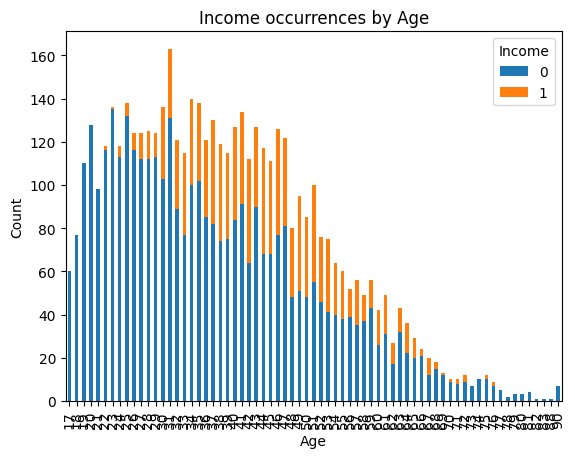

In [94]:
income_counts = data.groupby('Age')['Income'].value_counts().unstack(fill_value=0)

income_counts.plot(kind='bar', stacked=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Income occurrences by Age')
plt.show()

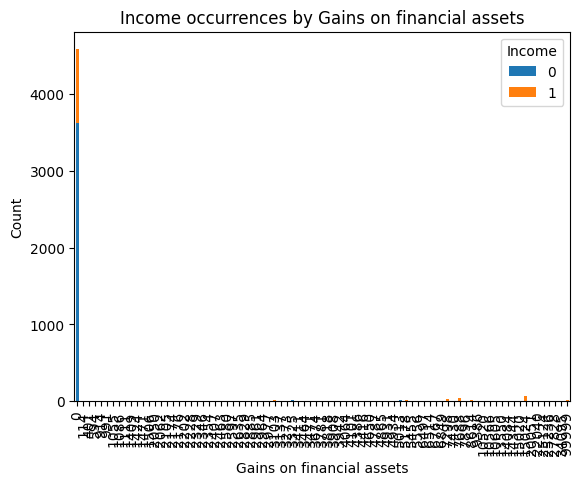

In [95]:
income_counts = data.groupby('Gains on financial assets')['Income'].value_counts().unstack(fill_value=0)

income_counts.plot(kind='bar', stacked=True)
plt.xlabel('Gains on financial assets')
plt.ylabel('Count')
plt.title('Income occurrences by Gains on financial assets')
plt.show()

## 3.3 Logistic Regression

In [38]:
pipe_log = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', LogisticRegression(random_state=99)) 
])
pipe_log

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier', LogisticRegression(random_state=99))])

### 3.3.1 Hyperparameter tuning

In [39]:
params_log = {}
# solver = ?
# previously tested: [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’] -> best = 'liblinear'
params_log['classifier__solver'] = ['newton-cg', 'lbfgs', 'liblinear']

# penalty = ?
# previously tested: [‘none’, ‘l1’, ‘l2’, ‘elasticnet’] -> best = 'l1'
params_log['classifier__penalty'] = ['l2', 'l1', 'none', 'elasticnet']

# C = ?
# previously tested: [0.1, 1, 10] -> best = 1 
params_log['classifier__C'] = [00.1, 0.1, 1, 10, 100]

# max_iter = ?
# previously tested: [100, 1000, 10000] -> best = 100 
params_log['classifier__max_iter'] = [10, 100, 1000, 10000]

# first iteration best score: 0.9026366008095295 (20% test split)

In [40]:
import warnings
warnings.filterwarnings('ignore')

# add verbose = 2 to have detailed infromation for each hyperparameter combination
grid_log = GridSearchCV(pipe_log, params_log, cv=5, scoring = 'roc_auc')
grid_log.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Employment '
                                                                          'type',
                                                                          'Level '
                                                                          'of '
                                                                          'education',
                                                                          'Martial '
                                                                          'status',
                                                                          'Employment '
                                                                          'area',
                                                                          'Partnership',
                                                                          'Ethnicity',
                                                                          'Country '
                                                                          'of '
                                                                          'birth']),
                                                                        ('num'...
                                                                          'working '
                                                                          'time']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encode',
                                                                                          OrdinalEncoder())]),
                                                                         ['Gender'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=99))]),
             param_grid={'classifier__C': [0.1, 0.1, 1, 10, 100],
                         'classifier__max_iter': [10, 100, 1000, 10000],
                         'classifier__penalty': ['l2', 'l1', 'none',
                                                 'elasticnet'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear']},
             scoring='roc_auc')

In [41]:
grid_log.best_score_

0.9022979335105422

In [42]:
grid_log.best_params_

{'classifier__C': 1,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

### 3.3.2 Final Logistic Regression

In [43]:
pipe_log_final = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', LogisticRegression(random_state=99, C = 1, max_iter = 100, penalty = 'l1', solver = 'liblinear')) 
])

## 3.4 SVM

In [44]:
pipe_svm = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', SVC(random_state=99)) 
])
pipe_svm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier', SVC(random_state=99))])

### 3.4.1 Hyperparameter tuning

In [45]:
params_svm = {}

# previously tested: [0.001, 1, 100] -> BEST: 100 -> again
params_svm['classifier__C'] = [0.001, 1, 100]

# previously tested: [1, 0.1, 0.01, 0.001, 0.0001] -> BEST: 0.001
params_svm['classifier__gamma'] = [1, 0.1, 0.01, 0.001, 0.0001]

# kernel = what type of basic function to use
# previously tested: ['linear', 'rbf'] -> BEST: rbf
params_svm['classifier__kernel'] = ['linear', 'rbf']

# first iteration best score: auc_score = 0.9135427084197859 (20% test split)

In [46]:
grid_svm = GridSearchCV(pipe_svm, params_svm, cv=5, scoring = 'roc_auc')
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Employment '
                                                                          'type',
                                                                          'Level '
                                                                          'of '
                                                                          'education',
                                                                          'Martial '
                                                                          'status',
                                                                          'Employment '
                                                                          'area',
                                                                          'Partnership',
                                                                          'Ethnicity',
                                                                          'Country '
                                                                          'of '
                                                                          'birth']),
                                                                        ('num'...
                                                                          'Schooling/training '
                                                                          'period',
                                                                          'Gains '
                                                                          'on '
                                                                          'financial '
                                                                          'assets',
                                                                          'Losses '
                                                                          'on '
                                                                          'financial '
                                                                          'assets',
                                                                          'Weekly '
                                                                          'working '
                                                                          'time']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encode',
                                                                                          OrdinalEncoder())]),
                                                                         ['Gender'])])),
                                       ('classifier', SVC(random_state=99))]),
             param_grid={'classifier__C': [0.001, 1, 100],
                         'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'classifier__kernel': ['linear', 'rbf']},
             scoring='roc_auc')

In [47]:
grid_svm.best_score_

0.9020922202278097

In [48]:
grid_svm.best_params_

{'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}

In [49]:
params_svm2 = {}

# previously tested: [500, 750, 1000] -> BEST: 1000 -> again
params_svm2['classifier__C'] = [1000, 1250, 2000]

# previously tested: [1, 0.1, 0.01, 0.001, 0.0001] -> BEST: 0.001
params_svm2['classifier__gamma'] = [0.01, 0.001, 0.0001]

# kernel = what type of basic function to use
# previously tested: ['linear', 'rbf'] -> BEST: rbf
params_svm2['classifier__kernel'] = ['linear', 'rbf']

# first iteration best score: auc_score = 0.9135427084197859 (20% test split)

In [50]:
grid_svm = GridSearchCV(pipe_svm, params_svm2, cv=5, scoring = 'roc_auc')
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Employment '
                                                                          'type',
                                                                          'Level '
                                                                          'of '
                                                                          'education',
                                                                          'Martial '
                                                                          'status',
                                                                          'Employment '
                                                                          'area',
                                                                          'Partnership',
                                                                          'Ethnicity',
                                                                          'Country '
                                                                          'of '
                                                                          'birth']),
                                                                        ('num'...
                                                                          'Schooling/training '
                                                                          'period',
                                                                          'Gains '
                                                                          'on '
                                                                          'financial '
                                                                          'assets',
                                                                          'Losses '
                                                                          'on '
                                                                          'financial '
                                                                          'assets',
                                                                          'Weekly '
                                                                          'working '
                                                                          'time']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encode',
                                                                                          OrdinalEncoder())]),
                                                                         ['Gender'])])),
                                       ('classifier', SVC(random_state=99))]),
             param_grid={'classifier__C': [1000, 1250, 2000],
                         'classifier__gamma': [0.01, 0.001, 0.0001],
                         'classifier__kernel': ['linear', 'rbf']},
             scoring='roc_auc')

In [51]:
grid_svm.best_score_

0.9027923158519184

In [52]:
grid_svm.best_params_

{'classifier__C': 1000,
 'classifier__gamma': 0.001,
 'classifier__kernel': 'rbf'}

### 3.4.2 Final SVM

In [53]:
pipe_svm_final = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', SVC(random_state=99, C = 1000, gamma = 0.001, kernel = 'rbf')) 
])

# 4. Model evaluation

## 4.1 Random Forests

In [54]:
X = data.iloc[:, :14]
y = data.iloc[:, 14]
y = y.astype('int')

In [55]:
pipe_rf_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, random_state=99))])

In [56]:
y_score_rf = pipe_rf_final.predict_proba(X_test)[:,1]

In [57]:
auc_rf = roc_auc_score(y_test, y_score_rf)
print(auc_rf)

0.8899839535085438


#### Confusion matrix

In [58]:
y_pred_rf = pipe_rf_final.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       756
           1       0.71      0.57      0.63       244

    accuracy                           0.84      1000
   macro avg       0.79      0.75      0.76      1000
weighted avg       0.83      0.84      0.83      1000



## 4.2 Logistic Regression

In [59]:
pipe_log_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier',
                 LogisticRegression(C=1, penalty='l1', random_state=99,
                                    solver='liblinear'))])

In [60]:
y_score_log = pipe_log_final.predict_proba(X_test)[:,1]

In [61]:
auc_log = roc_auc_score(y_test, y_score_log)
print(auc_log)

0.887327608639084


In [62]:
y_pred_log = pipe_log_final.predict(X_test)
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       756
           1       0.70      0.57      0.63       244

    accuracy                           0.84      1000
   macro avg       0.79      0.75      0.76      1000
weighted avg       0.83      0.84      0.83      1000



## 4.3 SVM

In [63]:
pipe_svm_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier', SVC(C=1000, gamma=0.001, random_state=99))])

In [64]:
#y_score_svm = pipe_svm_final.predict_proba(X_test)[:,1]

In [65]:
#auc_svm = roc_auc_score(y_test, y_score_svm)
#print(auc_svm)

In [66]:
#y_pred_svm = pipe_svm_final.predict(X_test)
#print(classification_report(y_test, y_pred_svm))

## 5.4 Precision-Recall Curves

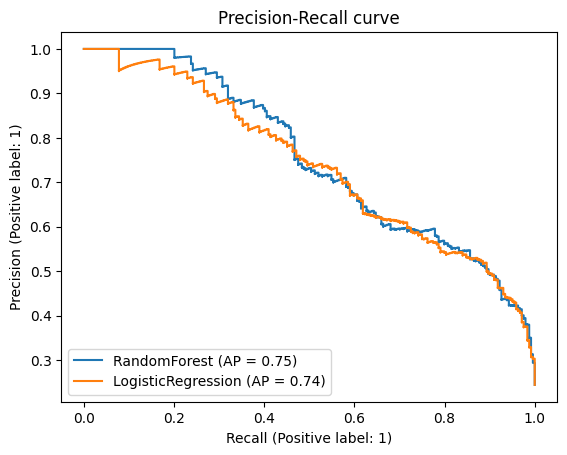

In [67]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
     y_test, y_score_rf, name="RandomForest", ax=ax)
PrecisionRecallDisplay.from_predictions(
     y_test, y_score_log, name="LogisticRegression", ax=ax)
#PrecisionRecallDisplay.from_predictions(
#     y_test, y_score_svm, name="SVM", ax=ax)
ax.set_title("Precision-Recall curve")
plt.show()